# Pitcher Injury Prediction
The goal of this notebook is to provide predictions of when pitchers are likely to be injured/at risk of injury by looking at the overall pitch data.

I have labeled the data by 'recent', which indicates whether the pitch was thrown within the last 14 days of the last pitch thrown before injury.

Ideas:
 - A basic logistic regression model on the recent indicator as a baseline
     - The logistic regression performs rather well, but only for a fixed player.
     - We do somewhat consistently seem to see the following as the strongest indicators:
         - 'release_extension', 'pfx_z', 'pfx_x', 'release_pos_z', 'release_pos_x'
     - The model suggests that for linear approximations, we need to stratify by player and pitch
 - Use UMAP to locate the pitches in a low dimensional space
 - Combine with a THD to see if there are informative regions across pitchers.
 
 - Current goal: use the THD to group all pitches into pitcher/pitch (perhaps in a supervised way)
     - Identify disconnected components?

In [3]:
# Some standard imports:
# Data manipulation:
import numpy as np
import pandas as pd
from datetime import datetime

# Interacting with files
import os

# Doing ML
import umap
# import umap.plot
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier as RFC

# Plotting things
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams
from matplotlib import cm

## Helpful functions:

In [59]:
# Converts the 'game_date' column of a statcast input
def parse_game_dates(data):
    df = data.copy()
    df['game_date'] = df['game_date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
    latest = max(df['game_date'])
    df['game_date'] = df['game_date'].apply(lambda x: latest - x)
    df['game_date'] = df['game_date'].dt.days
    return df

def preprocess(data, cols, test_size=0.2):
    df = data.copy()
    
    df = df.iloc[:,cols]
    df = df.groupby(df['player_name']).apply(parse_game_dates)
    # Boolean column of whether a pitch was thrown recently:
    # df['recent'] = df['game_date'] <= 14
    return train_test_split(df.dropna(), test_size=test_size)

# Splits into categorical and numerical data:
def sub_split_cat_num(df, subsetters=[], norm_feats=False, norm_mean=None, norm_var=None):
    data = df.dropna()
    
    if len(subsetters) > 0:
        s = [True for _ in range(len(data))]
        for subsetter in subsetters:
            s = s & (data[subsetter['col']] == subsetter['c_to'])
            
        data = data[s]
    cat_cols = ['pitch_type', 'player_name', 'description', 'stand', 'game_date', 'injury_day']
    num_cols = list(filter(lambda x: x not in cat_cols, data.columns))

    cat_data = data[cat_cols]
    num_data = data[num_cols]
    
    if norm_feats:
        if norm_mean is None:
            norm_mean = np.mean(num_data, axis=0)
            norm_var = np.var(num_data, axis=0)
        num_data = (num_data - norm_mean) / norm_var
        
    return cat_data, num_data, norm_mean, norm_var

# Applies a sigmoid scaling to time data to emphasize recent versus old events:
# x is the integer sequence, r is the relative location (between 0 and 1) that the sigmoid should be centered at
def sigmoid(x, r):
    n = len(x)
    center = int(n * r)
    return 1 - (1 / (1 + np.exp(30 * (-center+x) / n)))

## Read in Data:

In [60]:
file_names = os.listdir("scraped_data/")

In [97]:
n_players = 5
sampled_file_names = np.random.choice(file_names, n_players, replace=False)

In [98]:
# Load in the data:
raw_datas = [pd.read_csv(f"scraped_data/{file_name}", low_memory=False) for file_name in sampled_file_names]
raw_data = pd.concat(raw_datas)

## Preprocessing the data:

In [99]:
# Went in by-hand to pick out the columns that mattered:
# columns_that_matter = [0, 1, 2, 3, 4, 5, 9, 14, 17, 24, 25, 27, 28, 29, 30, 34, 35, 44, 45, 46, 47, 48, 49, 50, 51, 55, 56, 57, 76, 77, 79, 81, 82, 89]

# Omitting various variables (such as exit velocity): (and inning: 35, home_score:79)
columns_that_matter = [0, 1, 3, 4, 5, 9, 14, 17, 24, 25, 27, 28, 29, 30, 44, 45, 46, 47, 48, 49, 57, 76, 77, 81, 82, 89, 92]

In [100]:
train_data, test_data = preprocess(raw_data, columns_that_matter)

In [101]:
subsetters = []
# subsetters.append({'col' : 'player_name', 'c_to' : 'Verlander, Justin'})
# subsetters.append({'col' : 'pitch_type', 'c_to' : 'SL'})

train_cat, train_num, train_mean, train_var = sub_split_cat_num(train_data, subsetters, norm_feats=False)
test_cat, test_num, _, _ = sub_split_cat_num(test_data, subsetters, norm_feats=False, norm_mean=train_mean, norm_var=train_var)

## UMAP the data

In [102]:
# Instantiate and apply the umap reducer:
reducer = umap.UMAP(min_dist=0, n_neighbors=15, target_metric='euclidean', verbose=True)

# umap_train = reducer.fit_transform(train_num.to_numpy(), y=train_cat['recent'])
umap_train = reducer.fit_transform(train_num.to_numpy())
umap_test = reducer.transform(test_num.to_numpy())
# sliders_reduced = reducer.fit(num_sliders.to_numpy())

UMAP(min_dist=0, target_metric='euclidean', verbose=True)
Mon Jun 27 18:12:49 2022 Construct fuzzy simplicial set
Mon Jun 27 18:12:49 2022 Finding Nearest Neighbors
Mon Jun 27 18:12:49 2022 Building RP forest with 14 trees
Mon Jun 27 18:12:49 2022 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Mon Jun 27 18:12:50 2022 Finished Nearest Neighbor Search
Mon Jun 27 18:12:50 2022 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Mon Jun 27 18:13:04 2022 Finished embedding
Mon Jun 27 18:13:04 2022 Worst tree score: 0.87210464
Mon Jun 27 18:13:04 2022 Mean tree score: 0.87485093
Mon Jun 27 18:13:04 2022 Best tree score: 0.87848325
Mon Jun 27 18:13:04 2022 Forward diversification reduced edges from 510300 to 204057
Mon Jun 27 18:13:04 2022 Reverse diversification reduced edges from 204057 to 204057
Mon Jun 27 18:13:04 2022 Degree pruning reduced edges from 208256 to 208256
Mon Jun 27 18:13:04 2022 Resorting data and graph based on tree order
Mon Jun 27 18:13:04 2022 Building and compiling search function


Epochs completed:   0%|            0/100 [00:00]

### Looking at UMAP's output
Coloring output by recent pitches

In [103]:
sns.set_palette('deep')
cp = sns.color_palette()
cp

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

In [104]:
umap_train

array([[ 4.6556396 ,  1.5681258 ],
       [ 0.42029592, -0.72586685],
       [-0.22153811, -1.3115898 ],
       ...,
       [-1.0871516 ,  5.7229705 ],
       [ 0.37827212, -1.0192975 ],
       [ 0.01229472, -0.96780163]], dtype=float32)

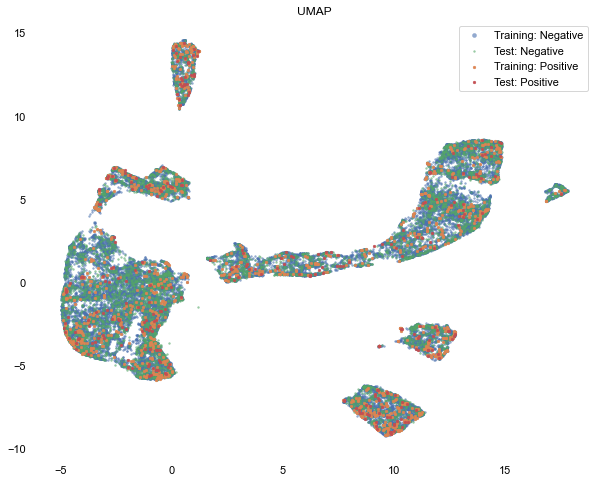

In [108]:
rcParams['figure.figsize'] = 10,8
sns.set_palette(sns.color_palette("flare"))
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white',
            'axes.edgecolor':'white', 
            'xtick.color':'black', 
            'ytick.color':'black', 
            'text.color':'black', 
            'axes.grid':False})

small, large = 15, 30
s_alpha, l_alpha = .6, 1.

train_f = train_cat['injury_day'] == 1
test_f = test_cat['injury_day'] == 1

plot = sns.scatterplot(x=umap_train[~train_f,0], y=umap_train[~train_f,1], marker='.', edgecolor=None, color=cp[0], alpha=s_alpha, s=small, label="Training: Negative")
plot = sns.scatterplot(x=umap_test[~test_f,0], y=umap_test[~test_f,1], marker='.', edgecolor=None, color=cp[2], alpha=s_alpha, s=small, label="Test: Negative")

plot = sns.scatterplot(x=umap_train[train_f,0], y=umap_train[train_f,1], marker='.', alpha=l_alpha, edgecolor=None, color=cp[1], s=large, label="Training: Positive")
plot = sns.scatterplot(x=umap_test[test_f,0], y=umap_test[test_f,1], marker='.', alpha=l_alpha, edgecolor=None, color=cp[3], s=large, label="Test: Positive")

plt.title("UMAP")

sz = 70
lgnd = plt.legend()
lgnd.legendHandles[0]._sizes = [sz]
# lgnd.legendHandles[1]._sizes = [sz]
# lgnd.legendHandles[2]._sizes = [sz]
# lgnd.legendHandles[3]._sizes = [sz]
# plt.savefig('JV_UMAP')
plt.show()

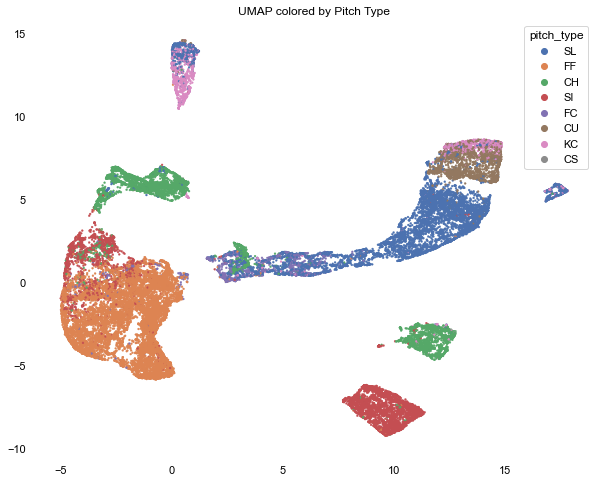

In [109]:
sns.scatterplot(x=umap_train[:,0], y=umap_train[:,1], s=small, edgecolor=None, marker='.', hue=train_cat['pitch_type'])
plt.title("UMAP colored by Pitch Type")
plt.savefig("_UMAP_pitchtype")
plt.show()

In [111]:
lr = LogisticRegression(max_iter=10_000, class_weight='balanced')
# feats = ['release_extension', 'pfx_z', 'pfx_x', 'release_pos_z', 'release_pos_x']
feats = list(train_num.columns)
lr.fit(train_num[feats], train_cat['injury_day'])
test_probs = lr.predict_proba(test_num[feats])
test_preds = lr.predict(test_num[feats])
train_probs = lr.predict_proba(train_num[feats])

In [114]:
# print(np.mean(test_preds == test_cat['recent']))
# print(np.mean(1-test_cat['recent']))

print(np.mean(test_probs[test_f][:,1]))
# print(np.mean(train_probs[train_cat['recent']][:,1]))
print(np.mean(test_probs[~test_f][:,1]))
# print(np.mean(train_probs[~train_cat['recent']][:,1]))

0.5321634692681769
0.45327243829543873


In [115]:
rescaled_coefs = np.abs(lr.coef_ / np.var(test_num, axis=0).to_numpy())
top_five = np.argsort(-rescaled_coefs)[0, :5]
bot_five = np.argsort(-rescaled_coefs)[0, -5:]
print(f"The five most predictive: {list(train_num.columns[top_five])}")
print(f"The five least predictive: {list(train_num.columns[bot_five])}")
# top_five

The five most predictive: ['release_extension', 'plate_x', 'pfx_x', 'pfx_z', 'release_pos_z']
The five least predictive: ['zone', 'az', 'vy0', 'at_bat_number', 'spin_axis']


In [261]:
embedding = num_reduced.embedding_
for year in list(set(year_data)):
    if year == 5:
        sns.scatterplot(x=embedding[year_data == year,0], y=embedding[year_data == year,1], s=20, label=year, alpha=0.1, color='pink')
    else:
        sns.scatterplot(x=embedding[year_data == year,0], y=embedding[year_data == year,1], s=1, label=year)
        
from matplotlib.cm import viridis

num_categories = len(set(cat_data['pitch_type']))

# colors = [viridis(float(i)/num_categories) for i in cat_data['pitch_type']]
sns.scatterplot(x=embedding[bad_month,0], y=embedding[bad_month,1], s=10, hue=cat_data['pitch_type'][bad_month], alpha=1.)

    
plt.legend()
# sns.scatterplot(embedding[~bad_day,0], embedding[~bad_day,1], alpha=0.1)
# sns.scatterplot(embedding[bad_day,0], embedding[bad_day,1])

NameError: name 'num_reduced' is not defined

In [267]:
os.chdir('THDs')

In [268]:
os.listdir()

['baseball_example',
 'baseball_example2',
 'baseball_example2.tar.gz',
 'baseball_example3',
 'baseball_example3.tar.gz',
 'baseball_example4',
 'baseball_example4.tar.gz',
 'baseball_example5.tar.gz',
 'baseball_example51',
 'baseball_example8',
 'baseball_example8.tar.gz',
 'bballdata.csv',
 'bball_example.tar.gz',
 'cat_bballdata.csv',
 'plrs_bballdata.csv',
 'plrs_num_bballdata.csv',
 'plrs_recent_bballdata.csv']

In [269]:
plrs_num = pd.read_csv('plrs_num_bballdata.csv')
plrs_rec = pd.read_csv('plrs_recent_bballdata.csv')

In [270]:
plrs_num

,Unnamed: 0,release_pos_x,release_pos_z,zone,balls,strikes,pfx_x,pfx_z,plate_x,plate_z,...,"Nelson, Jimmy","Paddack, Chris","Rodón, Carlos","Smith, Drew","Turley, Nik","Turnbull, Spencer","Vasto, Jerry","Verlander, Justin","Wilson, Justin","Yates, Kirby"
0,4017,-0.425766,4.567056,-0.435394,-0.945531,0.108998,-1.523725,0.919776,-0.991058,1.089199,...,0,0,0,0,0,0,0,1,0,0
1,2229,1.007670,2.237409,-0.103554,0.128768,-1.333610,1.736037,0.543709,-0.748984,-0.448907,...,0,0,1,0,0,0,0,0,0,0
2,13652,-0.432674,0.146699,-0.214168,2.277365,1.551606,-1.617306,1.324771,-0.295096,-0.119313,...,0,0,0,0,0,0,0,1,0,0
3,1180,-0.291057,-0.450646,-0.158861,-0.945531,-1.333610,1.034175,-1.756082,0.763977,0.010527,...,0,0,0,0,0,0,0,0,0,0
4,1836,1.024941,0.564841,0.283592,1.203066,0.108998,1.938798,0.572638,1.338902,-0.548784,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76876,10378,-0.639918,-0.510381,0.228286,0.128768,1.551606,1.158950,-2.349111,-1.066706,-1.058157,...,0,0,0,0,0,0,0,1,0,0
76877,2869,-0.494847,-7.320119,-0.158861,-0.945531,-1.333610,-2.490735,0.182107,0.537033,0.430011,...,0,0,0,0,0,0,0,0,0,1
76878,7844,-0.536296,1.819267,-0.214168,0.128768,1.551606,-1.913648,0.384604,0.310089,0.060466,...,0,0,0,0,0,0,0,1,0,0
76879,4721,-0.629556,0.385638,-0.048248,-0.945531,0.108998,0.815817,-3.028923,-0.007633,-0.498845,...,0,1,0,0,0,0,0,0,0,0


In [273]:
dfNew = plrs_rec.merge(plrs_num, left_index=True, right_index=True,
                 how='outer', suffixes=('', '_y'))

dfNew.drop(dfNew.filter(regex='_y$').columns, axis=1, inplace=True)

In [276]:
dfNew.to_csv("plrs_rec_num_bballdata.csv")